# exponentially-weighted moving-averages
In the following notebook, I will derive the equations for exponentially-weighted moving averages, and analyze how the curves' smoothness is affected by varying its numerous parameters.

In this notebook, we perform the following analyses:
 - [Varying $N$](#varying-n)
 - [Varying $\beta$](#varying-beta)
 - [Distance-wise term-weights](#distance-wise-term-weights)

In [81]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

In [82]:
data_files = ['washingtonDC-temp-USW00013743', 'washingtonDC-temp-USW00093721', 'washingtonDC-temp-USW00093738']
dates, tavg, tmax, tmin = None, None, None, None
load_file = f'../data/{data_files[1]}.h5'
with h5py.File(load_file, 'r') as f:
    print(f"loading... {f.keys()} from {load_file}")
    dates = np.array(f['DATE'])
    tavg = np.array(f['TAVG'])
    tmax = np.array(f['TMAX'])
    tmin = np.array(f['TMIN'])

print(f"Total data-points: {tavg.shape}")

loading... <KeysViewHDF5 ['DATE', 'TAVG', 'TMAX', 'TMIN']> from ../data/washingtonDC-temp-USW00093721.h5
Total data-points: (771,)


**Moving-averages**: a moving average is a smooting method used for redcing the randodm variation in the data, while preserving the overall trend.

Consider a sequence of data-points $<x_1, x_2, \dots, x_m>$. Then, we define a weighted moving-average $v_t$, at some point $t \in \{1, 2, \dots, m\}$ along the sequence,  as follows:

$$
\begin{align*}
v_t & = \frac{w_{t-(N-1)} x_{t-(N-1)} + w_{t-(N-2)} x_{t-(N-2)} + \dots + w_{t-1} x_{t-1} + w_t x_t}{w_{t-(N-1)} + w_{t-(N-2)} + \dots + w_{t-1} + w_t} \\
& = \frac{\sum_{i=0}^{N-1} w_{t-i} x_{t-i}}{\sum_{i=0}^{N-1} w_{t-i}} & \text{eq.1}\\
\newline
\text{where, } & w_{t-i} \text{ is the weight corresponding to } x_{t-i} \\
& N \in [1, m] \text{ is called the \textit{look-back period}}
\end{align*}
$$

In the case of exponentially-weighted moving-averages, the weights $<w_t, w_{t-1}, \dots, w_{t-(N-1)}>$ form a geometric-progression, i.e.

$$
\begin{align*}
w_{t-i} & = \beta^{i} \qquad \forall i \in \{0, 1, \dots, N-1\} & \text{eq.2} \\
\newline
\text{where, } & \beta \in (0,1] \text{ is called the \textit{smoothing-constant}}
\end{align*}
$$

from eq.1 and eq.2 above, we have

$$
\begin{align*}
v_t & = \frac{\sum_{i=0}^{N-1} w_{t-i} x_{t-i}}{\sum_{i=0}^{N-1} w_{t-i}} \\
& = \frac{\sum_{i=0}^{N-1} \beta^i x_{t-i}}{\sum_{i=0}^{N-1} \beta^i} \\
& = \frac{(1-\beta)\sum_{i=0}^{N-1} \beta^i x_{t-i}}{1-\beta^N} & \text{eq.3}
\end{align*}
$$

Now, consider the situation where $N$ is large-enough that $\beta^N \approx 0$. Then, from eq.3, we have

$$
\begin{align*}
v_t & = \frac{(1-\beta)\sum_{i=0}^{N-1} \beta^i x_{t-i}}{1-\beta^N} & \text{eq.4}\\
& \approx (1-\beta)\sum_{i=0}^{N-1} \beta^i x_{t-i} \\
& = (1-\beta)x_t + (1-\beta)\sum_{i=1}^{N-1} \beta^i x_{t-i} & \text{eq.5}
\end{align*}
$$

also, from eq.4, we have

$$
\begin{align*}
v_{t-1} & = (1-\beta)\sum_{i=0}^{N-1} \beta^i x_{t-1-i} && \\
& = \frac{1-\beta}{\beta} \sum_{i=0}^{N-1} \beta^{i+1} x_{t-1-i} && \text{multiply and divide by $\beta$} \\
& = \frac{1-\beta}{\beta} \sum_{j=1}^{N} \beta^j x_{t-j} && \text{set $i + 1 = j$} \\
& = \frac{1-\beta}{\beta} \sum_{j=1}^{N-1} \beta^j x_{t-j} + \biggl(\frac{1-\beta}{\beta}\biggr) \beta^N x_{t-N} && \\
& \approx \frac{1-\beta}{\beta} \sum_{j=1}^{N-1} \beta^j x_{t-j} && \text{since, $\beta^N \approx 0$} \\
\implies & \beta v_{t-1} = (1-\beta)\sum_{j=1}^{N-1} \beta^j x_{t-j} && \text{eq.6}
\end{align*}
$$

combining eq.5 and eq.6, we get

$$
v_t = (1-\beta)x_t + \beta v_{t-1} \qquad \text{eq.7}
$$

> **Caution**: the above eq.7 is only valid, in its stated form, when $\beta^N \approx 0$. So, for data-points ($x_t$) at the beginning of the sequence, where $t < N$, we will have to eq.3, i.e.
>
> $$
> v_t = \frac{(1-\beta)\sum_{i=0}^{t-1} \beta^i x_{t-i}}{1-\beta^t} \qquad \text{where, $t \lt N$}
> $$
>
> **Note**: often, when using eq.7, we consider a $\textit{bias-correction-factor}$ as follows:
>
> $$
> \begin{align*}
> v_{t}' & = (1 - \beta)x_t + \beta v_{t-1}' \\
> \newline
> \text{where, } & v_{t}' \text{ is the biased moving-average, and} \\
> & v_{t-1}' \biggr|_{t=1} = v_{0}' = 0
> \end{align*}
> $$
> then, we have
> $$
> v_t = \frac{v_{t}'}{1 - \beta^t}
> $$

In [83]:
def get_look_back(t: int, N: int):
    return min(t, np.inf if not N else N)

def moving_avg(sequence: np.ndarray, t: int, N: int, beta: np.float64) -> np.float64:
    """
    param N: if set to None, then the look-back period is set equal to 't'
    """
    assert t <= sequence.size

    if not N: N = np.inf # if 'N' is None, then look-back period should be 't'
    lbp = get_look_back(t, N)

    weights = np.array([beta] * lbp)
    weights[0] = 1
    weights = np.flip(np.cumprod(weights))
    
    # the following line doesn't work when beta = 1, hence commented
    # (1.0 - beta) * np.sum(np.multiply(sequence[max(0, t-N):t], weights)) / (1.0 - weights[0] * beta) # since, weights[0] = np.power(beta, lbp-1)
    return np.sum(np.multiply(sequence[max(0, t-N):t], weights)) / np.sum(weights)

def smooth_sequence(sequence: np.ndarray, N: int=None, beta: np.float64=0.6) -> np.ndarray:
    print(f"Expoentially-weighted moving-average: {{N: {N}, beta: {beta}}}")

    smooth_seq_acurate = np.zeros_like(sequence)
    smooth_seq_approx = np.zeros_like(sequence)
    vt_prev = 0
    for idx, xt in np.ndenumerate(sequence):
        t = idx[0] + 1
        smooth_seq_acurate[idx[0]] = moving_avg(sequence, t=t, N=N, beta=beta)
        
        smooth_seq_approx[idx[0]] = (1-beta) * xt + beta * vt_prev
        vt_prev = smooth_seq_approx[idx[0]]
        smooth_seq_approx[idx[0]] /= (1 - np.power(beta, t))
    
    return smooth_seq_acurate, smooth_seq_approx

## # varying $N$
From the following plot, we can see that:
* At $N \ge 10$: the smoothing doesn't change much as $N$ increases, since, the plots for $N = 8$ and $N = 32$, are almost identical.
* At $N \lt 10$: there is significant change in smoothing as $N$ varies, since, the plots for $N = 2$ and $N = 8$ diverge quite frequently.

Expoentially-weighted moving-average: {N: 2, beta: 0.6}
Expoentially-weighted moving-average: {N: 8, beta: 0.6}


C:\Users\Harsha\AppData\Local\Temp/ipykernel_3964/2133572959.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=x_axis, y=tavg_acc, label=f"$N = {n}$", linestyle="-", marker=",")
C:\Users\Harsha\AppData\Local\Temp/ipykernel_3964/2133572959.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=x_axis, y=tavg_acc, label=f"$N = {n}$", linestyle="-", marker=",")


Expoentially-weighted moving-average: {N: 32, beta: 0.6}


C:\Users\Harsha\AppData\Local\Temp/ipykernel_3964/2133572959.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=x_axis, y=tavg_acc, label=f"$N = {n}$", linestyle="-", marker=",")


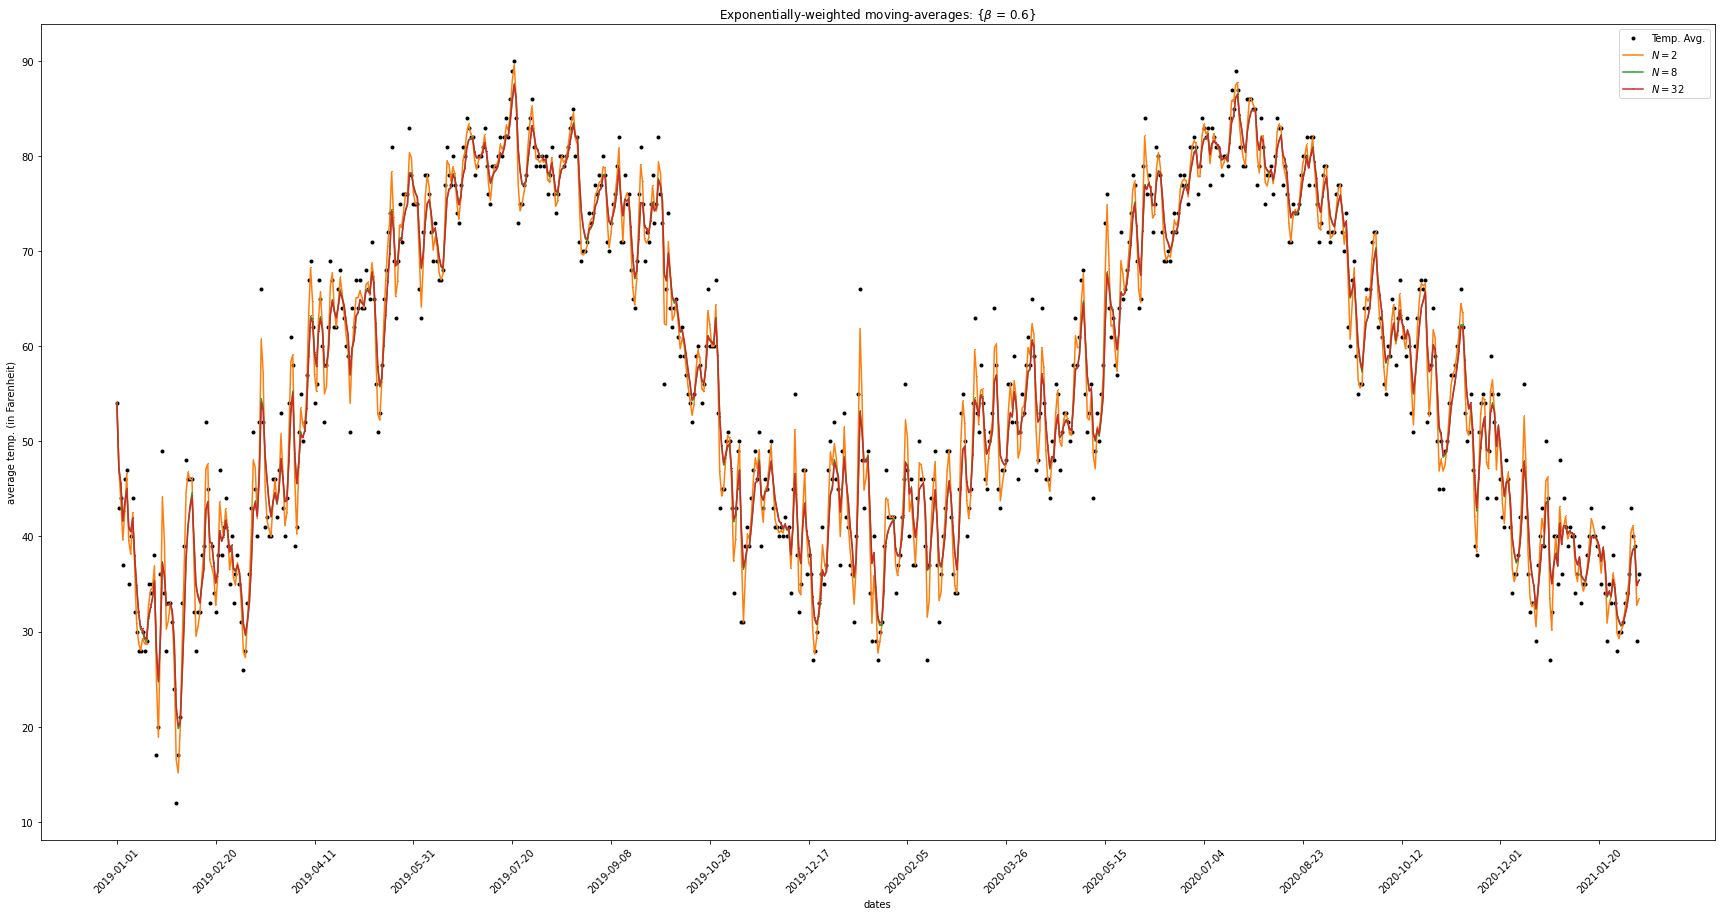

In [85]:
N = [2, 8, 32]
beta = 0.6
x_axis = dates

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 15))
ax.set_xlabel(xlabel="dates")
ax.set_ylabel(ylabel="average temp. (in Farenheit)")
ax.set_title(f"Exponentially-weighted moving-averages: {{$\\beta$ = {beta}}}")

ax.plot_date(x=x_axis, y=tavg, xdate=True, ydate=False, markersize=4, markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, label="Temp. Avg.")
for n in N:
    tavg_acc, _ = smooth_sequence(tavg, n, beta=beta)
    ax.plot_date(x=x_axis, y=tavg_acc, label=f"$N = {n}$", linestyle="-", marker=",") 

ax.set_xticks(np.arange(start=0, stop=tavg.size, step=50))
ax.tick_params('x', labelrotation=45)

ax.legend()
plt.show()

## # varying $\beta$
The plot below clearly shows that, as the value of $\beta$ increases, the smoothing effect increases.

Expoentially-weighted moving-average: {N: 32, beta: 0.5}
Expoentially-weighted moving-average: {N: 32, beta: 0.7}


C:\Users\Harsha\AppData\Local\Temp/ipykernel_3964/321322879.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=x_axis, y=tavg_acc, label=f"$\\beta = {b}$", linestyle="-", marker=",")
C:\Users\Harsha\AppData\Local\Temp/ipykernel_3964/321322879.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=x_axis, y=tavg_acc, label=f"$\\beta = {b}$", linestyle="-", marker=",")
C:\Users\Harsha\AppData\Local\Temp/ipykernel_3964/321322879.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(x=x_axis, y=tavg_acc, label=f"$\\beta = {b}$", linestyle="-", marker=",")


Expoentially-weighted moving-average: {N: 32, beta: 0.9}


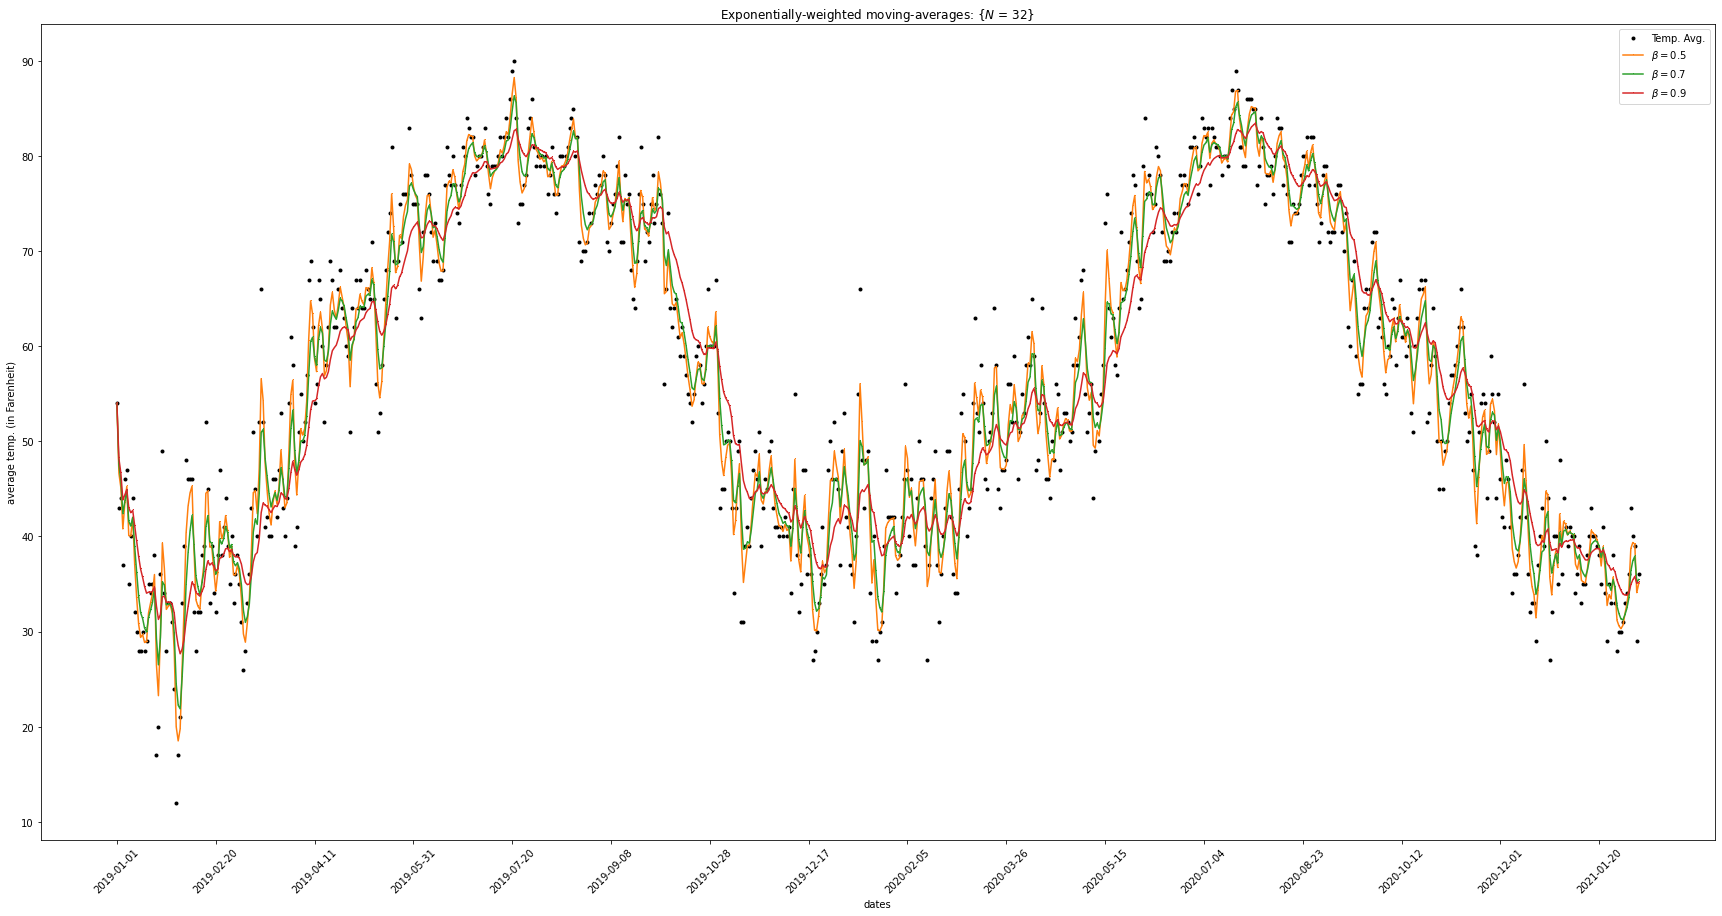

In [86]:
N = 32
beta = [0.5, 0.7, 0.9]
x_axis = dates

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30, 15))
ax.set_xlabel(xlabel="dates")
ax.set_ylabel(ylabel="average temp. (in Farenheit)")
ax.set_title(f"Exponentially-weighted moving-averages: {{$N$ = {N}}}")

ax.plot_date(x=x_axis, y=tavg, xdate=True, ydate=False, markersize=4, markerfacecolor='black', markeredgecolor='black', markeredgewidth=0, label="Temp. Avg.")
for b in beta:
    tavg_acc, _ = smooth_sequence(tavg, N, beta=b)
    ax.plot_date(x=x_axis, y=tavg_acc, label=f"$\\beta = {b}$", linestyle="-", marker=",") 

ax.set_xticks(np.arange(start=0, stop=tavg.size, step=50))
ax.tick_params('x', labelrotation=45)

ax.legend()
plt.show()

## # distance-wise term-weights
The following plot shows how the weights for the data-points (i.e. $w_{t-i} = \beta^i$) vary as we move away from the focal data-point (i.e. $x_t$), for different values of $\beta$.

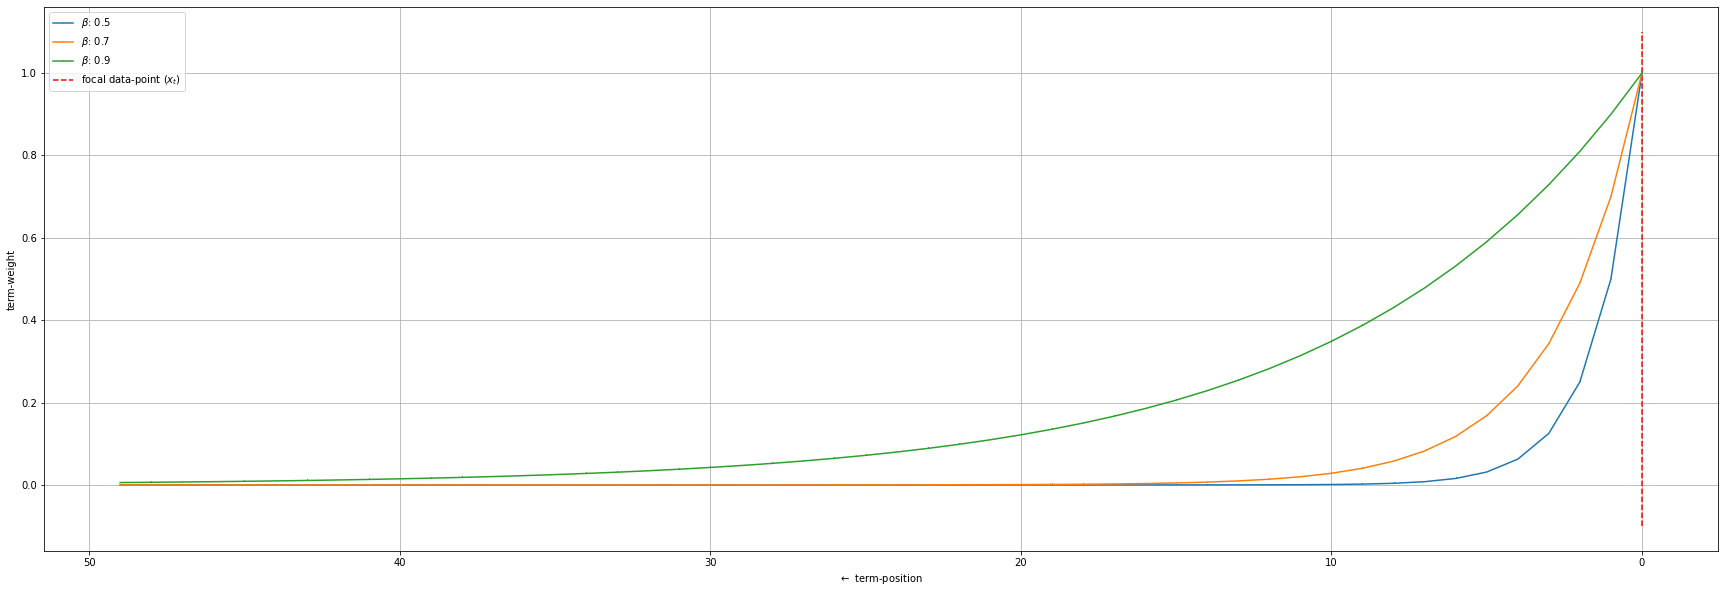

In [108]:
x_axis = np.arange(start=0, stop=50, step=1).reshape((-1,1))
beta = np.array(beta).reshape((1, -1)) # beta --> array from the code in "varying \beta"

fig, ax = plt.subplots(figsize=(30, 10))
ax.set_xlabel(xlabel="$\leftarrow$ term-position")
ax.set_ylabel(ylabel="term-weight")
ax.grid(b=True)

lines = ax.plot(x_axis, np.power(beta, x_axis), linestyle="-", marker=",") 
l = ax.vlines(0, ymin=-0.1, ymax=1.1, color='red', linestyles='--', linewidths=1.5)

ax.invert_xaxis()
ax.legend([*lines, l], [*[f"$\\beta$: {b}" for b in beta[0,:]], 'focal data-point ($x_t$)'] )
plt.show()